In [1]:
import numpy as np
import FuncParcel
from scipy import stats
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib as mpl
from matplotlib import colors
import pickle
from collections import Counter
%matplotlib inline
from sklearn.metrics import mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as RAND

# Network Based Parcellation

In [2]:
#path to files ncessary for parcellation
MGHadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')
NKIadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_645_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')


# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxels_ijk_indices', dtype = int)

subcorticalcortical_ROIs = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Cortical_CI_plus_thalamus_ROIs')
subcortical_voxels = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxel_indices')
cortical_ROIs =np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')
Cortical_CI = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')


#call function
_, MGH_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(MGHadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)
_, NKI_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(NKIadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)

## Display thalamic parcellation over MNI template

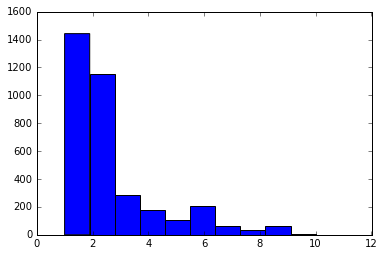

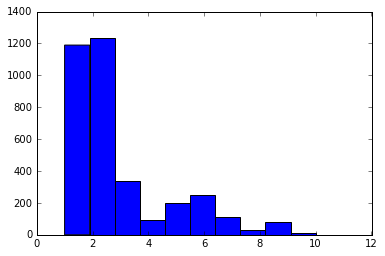

NMI = 0.638317078276
RAND = 0.472090609335


In [4]:
# sort CI vector
def sort_CI(Thalamo_ParcelCIs):
    CIs = np.zeros(len(Thalamus_voxel_coordinate))
    for i, thalamus_voxel_index in enumerate(Thalamus_voxel_coordinate[:,3]):
        CIs[i] = Thalamo_ParcelCIs[thalamus_voxel_index][0]
    CIs = CIs.astype(int)
    return CIs
                        

NKI_CIs = sort_CI(NKI_ParcelCIs)
MGH_CIs = sort_CI(MGH_ParcelCIs)

plt.hist(NKI_CIs, bins=np.max(np.unique(NKI_CIs)))
plt.show()
plt.hist(MGH_CIs, bins=np.max(np.unique(MGH_CIs)))
plt.show()
print 'NMI =', NMI(NKI_CIs, MGH_CIs)
print 'RAND =', RAND(NKI_CIs, MGH_CIs)

np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Thalamus_WTA_CIs', MGH_CIs, )
np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_Thalamus_WTA_CIs', NKI_CIs, )
#FuncParcel.save_object(MGH_CIs, '/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Thalamus_CIs')

In [4]:
np.unique(MGH_CIs)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [36]:
def visualize_parcellation(CIs, cmap, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i].astype(int)
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[40:70, 25:65, Z_slice], cmap='gray', interpolation='nearest')
        plt.imshow(Mask[40:70, 25:65, Z_slice],cmap=cmap, interpolation='none', vmin = 1, vmax=len(np.unique(CIs)))
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(18.5,13.5) 
    
    plt.savefig(savepath, bbox_inches='tight')

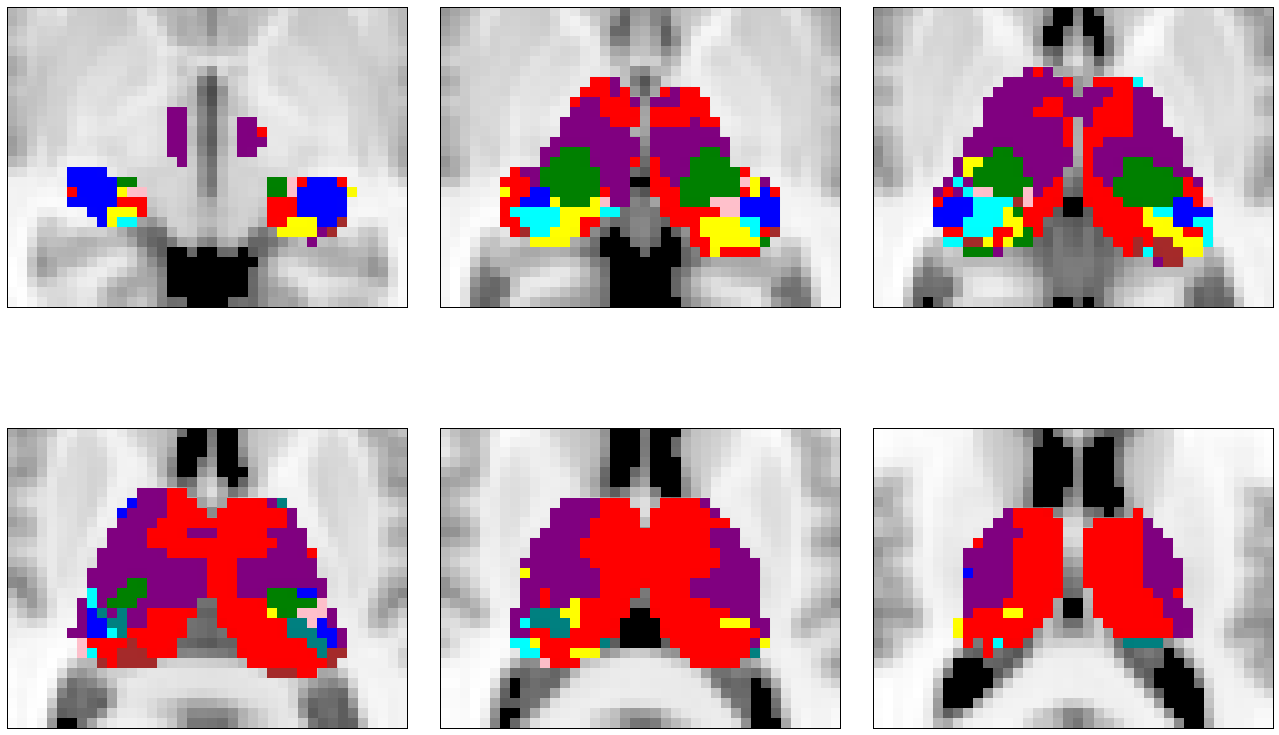

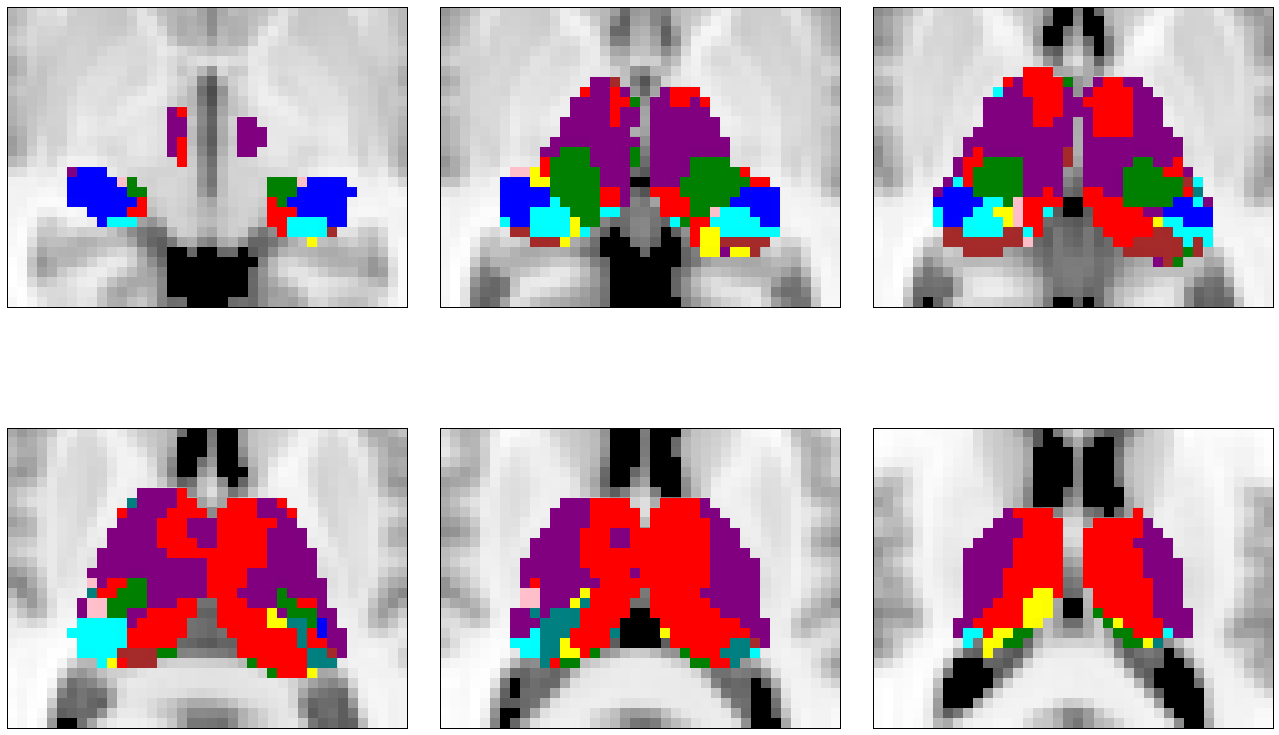

In [37]:
cmap = colors.ListedColormap(['red', 'purple', 'green', 'yellow', 'cyan', 'blue', 'brown', 'pink', 'teal', 'pink'])
visualize_parcellation(NKI_CIs, cmap, 'Data/MGH_CI_WTA_Tha_Parcel.png')
visualize_parcellation(MGH_CIs, cmap, 'Data/NKI_CI_WTA_Tha_Parcel.png')

# Parcellation based on Cortex ROIs

In [4]:
NKIadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_mx_645_cortex_plus_thalamus_parcorrmatavg')
MGHadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_cortex_plus_thalamus_parcorrmatavg')

subcorticalcortical_ROIs = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Cortex_plus_thalamus_ROIs')
subcortical_voxels = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxel_indices')
cortical_ROIs =np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Cortex_ROIs')
Cortical_CI = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Cortex_ROIs')


#call function
_, MGH_CortexParcels, _ = FuncParcel.parcel_subcortical_network(MGHadjmat, \
            subcorticalcortical_ROIs, subcortical_voxels, cortical_ROIs, Cortical_CI)
_, NKI_CortexParcels, _ = FuncParcel.parcel_subcortical_network(NKIadjmat, \
            subcorticalcortical_ROIs, subcortical_voxels, cortical_ROIs, Cortical_CI)

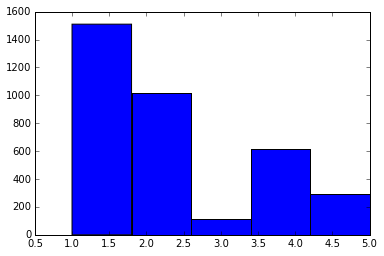

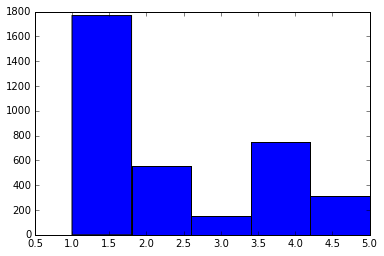

NMI =  0.560457808943
RAND =  0.463360604463


In [6]:
NKI_CortexCIs = sort_CI(NKI_CortexParcels)
MGH_CortexCIs = sort_CI(MGH_CortexParcels)
plt.hist(NKI_CortexCIs, bins=np.max(np.unique(NKI_CortexCIs)))
plt.show()
plt.hist(MGH_CortexCIs, bins=np.max(np.unique(MGH_CortexCIs)))
plt.show()
print 'NMI = ', NMI(MGH_CortexCIs, NKI_CortexCIs)
print 'RAND = ', RAND(MGH_CortexCIs, NKI_CortexCIs)

In [12]:
MGH_CortexCIs

Parcel_path = '/home/despoB/connectome-thalamus/Thalamic_parcel'
path_to_ROIs = '/home/despoB/connectome-thalamus/ROIs'

atlas_path = path_to_ROIs+'/Thalamus_indices.nii.gz' 
image_path = Parcel_path + '/MGH_anatomical_based_thalamus_parcel.nii.gz' 
ROI_list = path_to_ROIs + '/thalamus_voxel_indices' 
FuncParcel.make_image(atlas_path, image_path, ROI_list, MGH_CortexCIs)


In [13]:
cmap = colors.ListedColormap(['Indigo','orange','violet','hotpink','limegreen'])
visualize_parcellation(NKI_CortexCIs, cmap,'Data/MGH_Cortex_Tha_Parcel.png' )
visualize_parcellation(MGH_CortexCIs, cmap,'Data/NKI_Cortex_Tha_Parcel.png' )

NameError: name 'visualize_parcellation' is not defined

# Visualize nodal properties (PC, WMDs... etc)

In [61]:
def visualize_nodal_property(CIs, lb, ub, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i]
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    cmap = plt.get_cmap('spring')
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[40:70, 25:65, Z_slice], cmap='gray', interpolation='nearest')
        im=plt.imshow(Mask[40:70, 25:65, Z_slice],cmap=cmap, interpolation='none', vmin =lb, vmax=ub)
        plt.ylim(plt.ylim()[::-1])

    cbar_ax = fig.add_axes([0.92,.25,.025,.52])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[lb, ub])
    cbar.ax.tick_params(labelsize=40)
    fig.set_size_inches(18.5,10.5)
    plt.savefig(savepath, bbox_inches='tight')

###PC = Participation coefficient
###BNWR = between network connectivity weight ratio (divide by totoal weight of each node)
###WMD = within nodule degree zscore
### bcc = between network centrality

###all of these were  calculated using thalamocortical connections (ignoring within thalamus connections), or only within thalamus weights (ignoring thalamocortical connections).

In [55]:
# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxels_ijk_indices', dtype = int)
#load data
Tha_PCs = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_PCs', "rb"))
Tha_BNWR = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_BNWR', "rb"))
Tha_NNC = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_NNCs', "rb"))
Tha_WMD = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_WMDs', "rb"))
within_Tha_PCs = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/NKI_within_Tha_PCs', "rb"))
within_Tha_WMD = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/NKI_within_Tha_WMDs', "rb"))
Tha_bcc = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_bcc', "rb"))
#visualize_nodal_property(Tha_NNC[320:]/15, 0, 9)

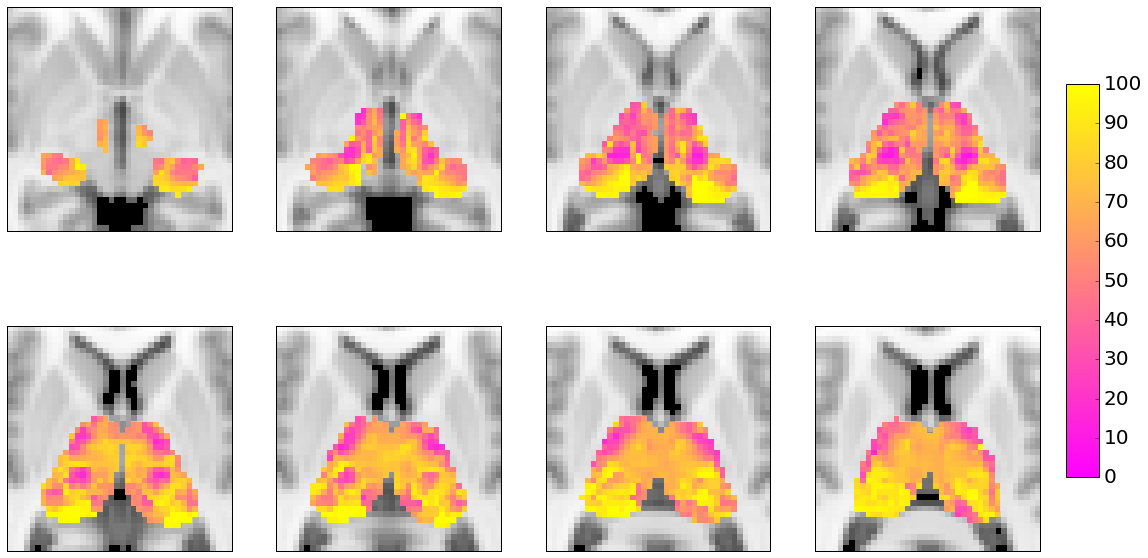

In [12]:
PC = pickle.load(open('/home/despoB/kaihwang/Rest/Graph/MGH_avemat_tha_nodal_pcorr_BNWRs', 'rb'))
visualize_nodal_property(PC[333:],0,100,'Data/WTA_PC.png')

##thalamocortical PC

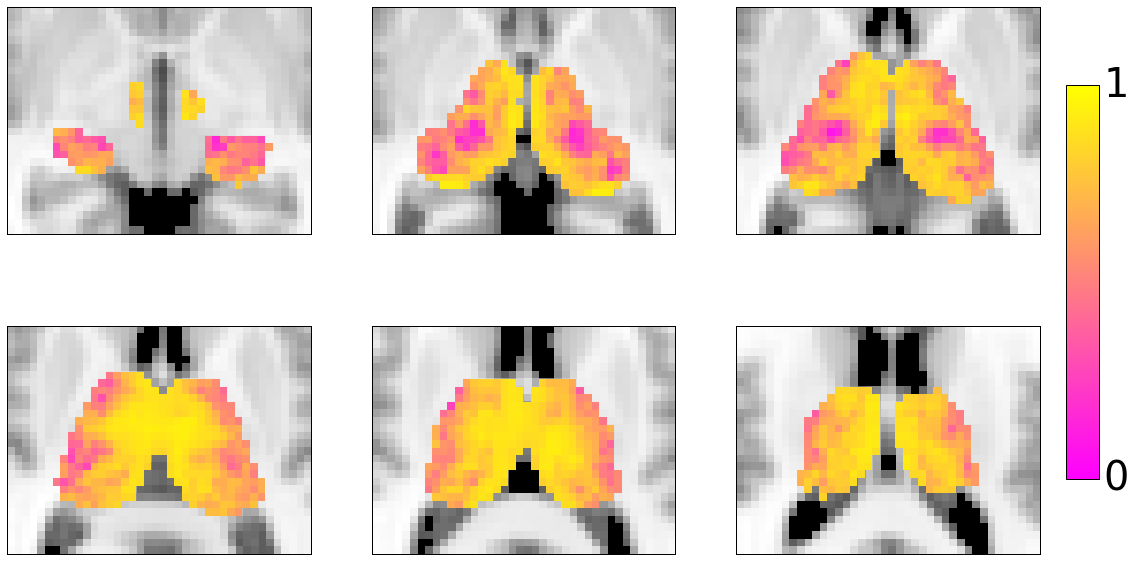

In [62]:
visualize_nodal_property(Tha_PCs[320:]/13.5, 0, 1, 'Data/Tha_PC.png')

##thalamocortical BNWR


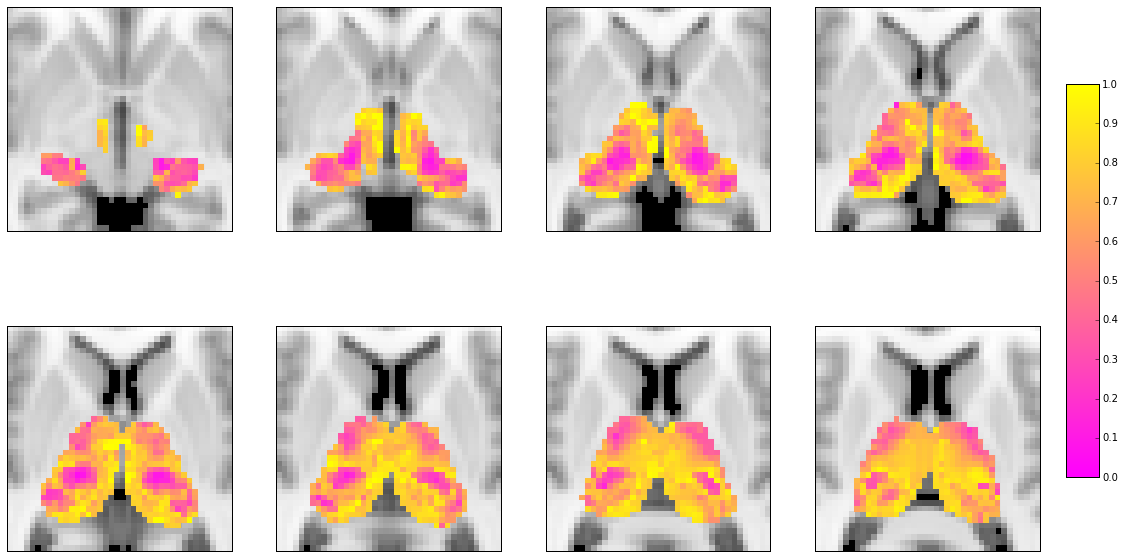

In [118]:
visualize_nodal_property(Tha_BNWR[320:]/15, 0, 1, 'Data/Tha_BNWR.png')


## NCC

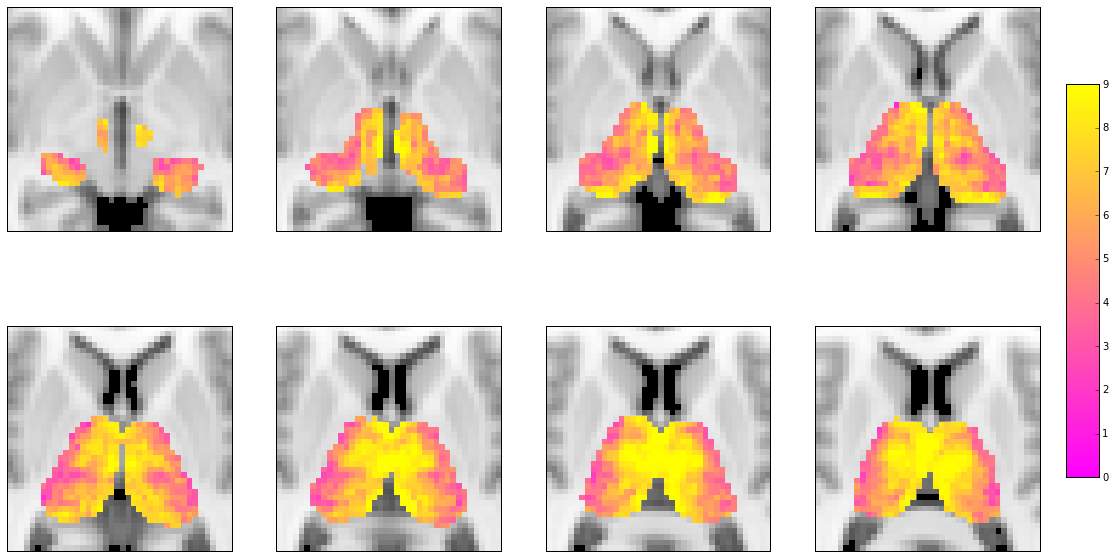

In [119]:
visualize_nodal_property(Tha_NNC[320:]/15, 0, 9, 'Data/Tha_NNC.png')

## thalamocortical WMD

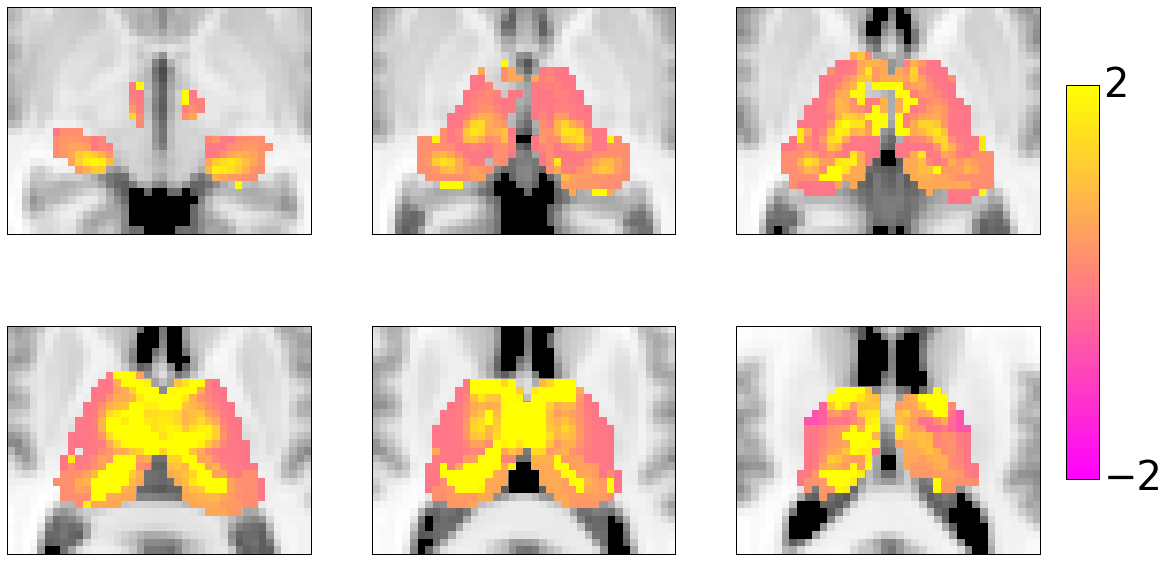

In [63]:
visualize_nodal_property(Tha_WMD[320:]/15, -2, 2, 'Data/Tha_WMD.png')

## within thalamus PC and WMD

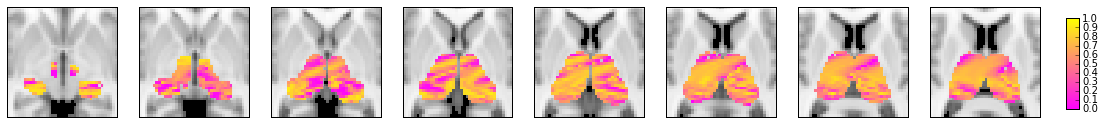

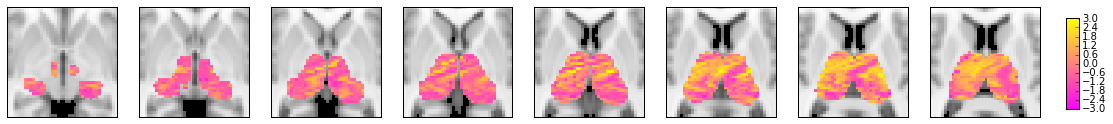

In [27]:
visualize_nodal_property(within_Tha_PCs[320:]/13.5, 0, 1)
visualize_nodal_property(within_Tha_WMD[320:]/15,-3, 3)

## SNR 

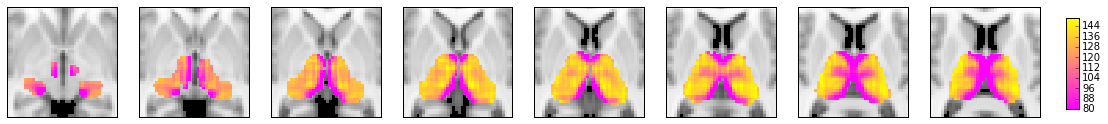

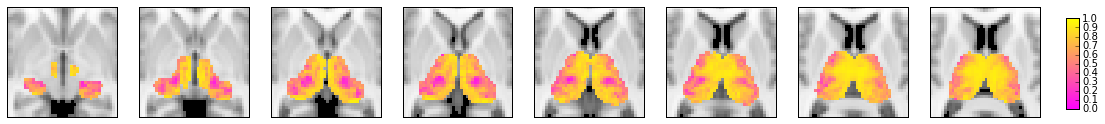

In [28]:
tsnr = np.loadtxt('/home/despoB/kaihwang/Rest/ROIs/tsnr')
visualize_nodal_property(tsnr, 80, 150)
visualize_nodal_property(Tha_PCs[320:]/13.5, 0, 1)

## bcc

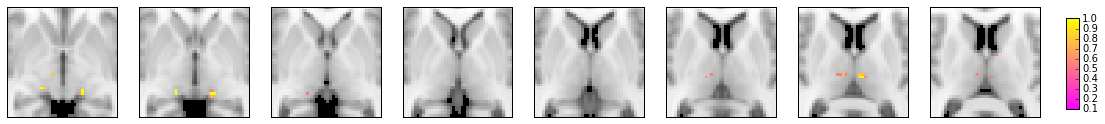

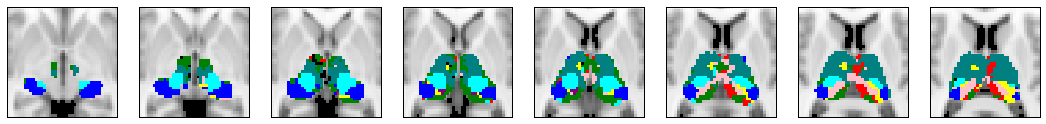

In [60]:
Tha_bcc[Tha_bcc<0.5] = np.nan
visualize_nodal_property(Tha_bcc[320:],0.1,1)
cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
visualize_parcellation(MGH_CIs, cmap)

## FSL atlas

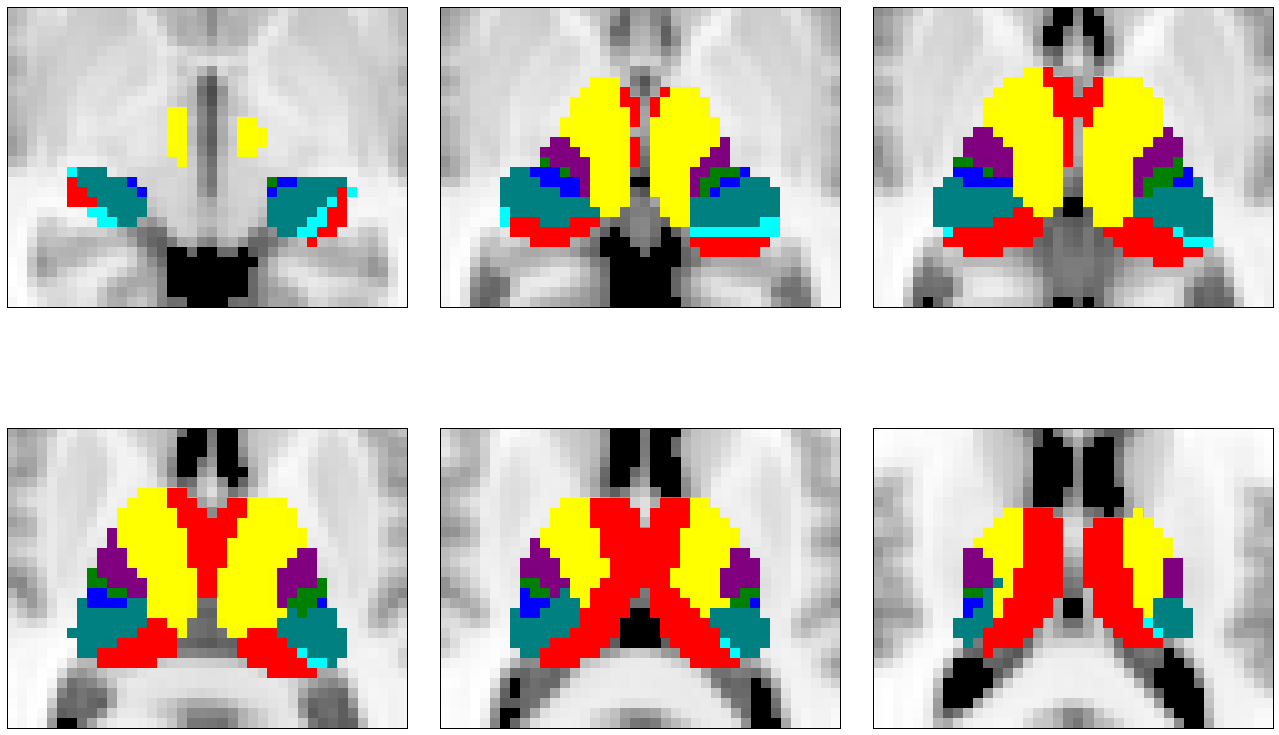

In [39]:
cmap = colors.ListedColormap(['green', 'blue', 'cyan', 'yellow', 'purple', 'teal', 'red'])
Thalamus_ana_parcel = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/fsl_thalamus_ana_parcel') 
visualize_parcellation(Thalamus_ana_parcel, cmap,'Data/FSLtha_Parcel.png' )

## Morel atlas

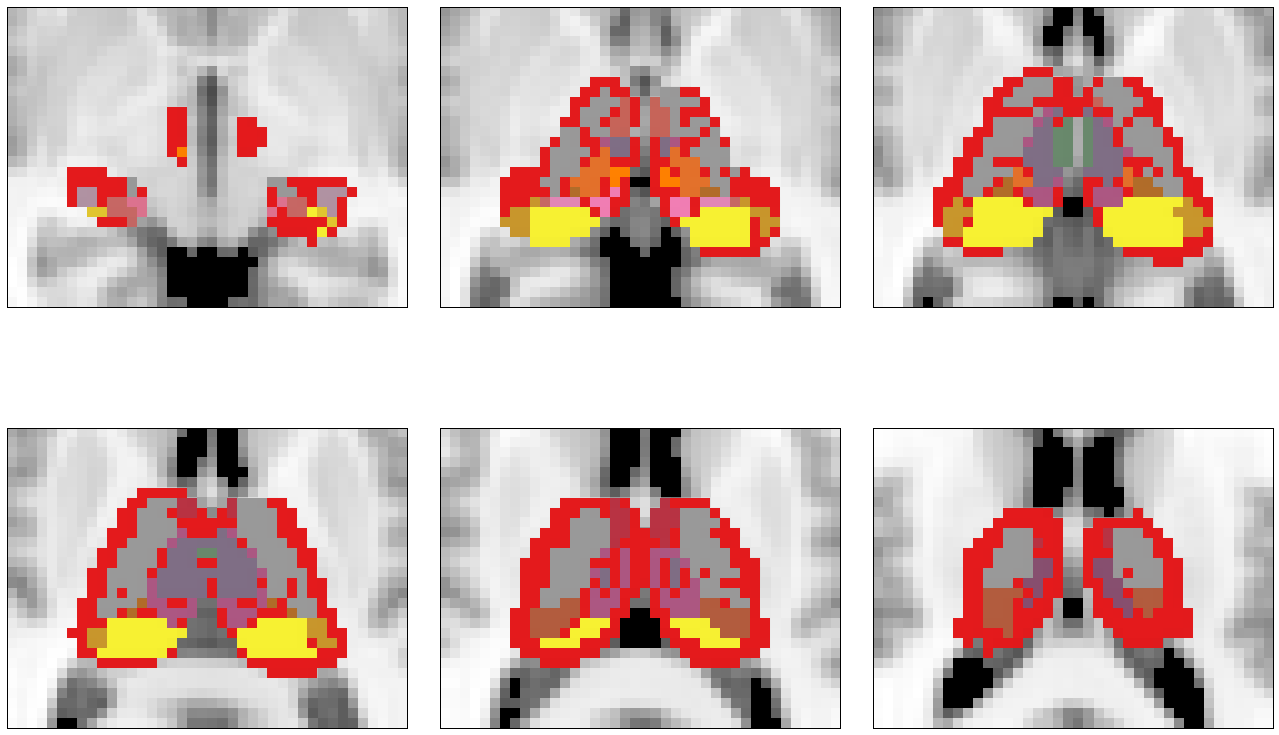

In [52]:
cmap = 'Set1'
Thalamus_ana_parcel = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/Morel_parcel') 
Thalamus_ana_parcel = Thalamus_ana_parcel-10
Thalamus_ana_parcel
visualize_parcellation(Thalamus_ana_parcel, cmap,'Data/FSLtha_Parcel.png' )

In [46]:
Thalamus_ana_parcel[Thalamus_ana_parcel==0]=np.nan